# Oscillon Formation Post-Inflation — Diagnostic Notebook

Reproducing results from **Aurrekoetxea, Clough & Muia (arXiv:2304.01673)**
using the spherically symmetric NR code *enGRenage* with Modified Gravity extensions.

**Potential:** α-attractor T-model  
$$V(\phi) = \frac{m^2 \mu^2}{2}\left(1 - e^{\phi/\mu}\right)^2$$

**Diagnostics reproduced:**
- Density contrast $\delta_c = \rho_c / \bar\rho - 1$ (Fig. 4 top)
- Central energy density $\rho_c$ evolution (Fig. 4 bottom)
- Compactness $\mathcal{C} = GM/R$ (Fig. 1)
- Oscillon mass $M$ and radius $R$ (Fig. 5)
- Energy-density profiles $\rho(r)$ at selected times (Fig. 2)
- Multi-amplitude comparison

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/user/leuven/384/vsc38419/0scillons/source')

from core.grid import Grid
from core.rhsevolution_MG import *
from core.spacing import *
from core.display import *
from core.statevector import *
from matter.scalarmatter_MG import *
from initialdata.ModifiedGravityInitialConditions import *
from backgrounds.sphericalbackground import *
from bssn.constraintsdiagnostic import *
from bssn.oscillondiagnostic import (get_oscillon_diagnostic,
                                     plot_density_profiles_at_times,
                                     plot_paper_diagnostics,
                                     plot_density_contrast_comparison)

## 1. Paper Parameters — Table I (arXiv:2304.01673)

| $\mu$ [M$_{\rm Pl}$] | $\phi_{\rm reh}$ [M$_{\rm Pl}$] | $\dot\phi_{\rm reh}$ [$m\,$M$_{\rm Pl}$] | $H_{\rm reh}$ [$m$] |
|:---:|:---:|:---:|:---:|
| 0.10 | $-1.32906\times10^{-1}$ | $5.19917\times10^{-2}$ | $3.67637\times10^{-2}$ |
| 0.09 | $-1.21893\times10^{-1}$ | $4.72136\times10^{-2}$ | $3.33851\times10^{-2}$ |
| **0.08** | $-1.10495\times10^{-1}$ | $4.2354\times10^{-2}$ | $2.99488\times10^{-2}$ |
| 0.07 | $-9.86792\times10^{-2}$ | $3.74094\times10^{-2}$ | $2.64525\times10^{-2}$ |
| 0.06 | $-8.64102\times10^{-2}$ | $3.23761\times10^{-2}$ | $2.28934\times10^{-2}$ |
| 0.05 | $-7.36454\times10^{-2}$ | $2.72499\times10^{-2}$ | $1.92686\times10^{-2}$ |
| 0.04 | $-6.03334\times10^{-2}$ | $2.20256\times10^{-2}$ | $1.55744\times10^{-2}$ |

Perturbation amplitudes (RMS): $A = \sqrt{\langle\delta\phi^2\rangle}$
- Large:  $\langle\delta\phi^2\rangle \approx 10^{-8}$ → $A = 10^{-4}$
- Medium: $\langle\delta\phi^2\rangle \approx 10^{-10}$ → $A \approx 3.16\times10^{-5}$
- Small:  $\langle\delta\phi^2\rangle \approx 10^{-12}$ → $A = 10^{-6}$

In [2]:
# ============================================================
#  CONFIGURATION — change mu and amplitude here
# ============================================================

TABLE_I = {
    0.10: (-1.32906e-1, 5.19917e-2, 3.67637e-2),
    0.09: (-1.21893e-1, 4.72136e-2, 3.33851e-2),
    0.08: (-1.10495e-1, 4.2354e-2,  2.99488e-2),
    0.07: (-9.86792e-2, 3.74094e-2, 2.64525e-2),
    0.06: (-8.64102e-2, 3.23761e-2, 2.28934e-2),
    0.05: (-7.36454e-2, 2.72499e-2, 1.92686e-2),
    0.04: (-6.03334e-2, 2.20256e-2, 1.55744e-2),
}

# ---- Choose mu (self-interaction parameter) ----
mu = 0.08

# ---- Look up reheating values from Table I ----
u_val, v_val, H_reh_expected = TABLE_I[mu]

# ---- Scalar field mass (code units: m = 1) ----
scalar_mu = 1

# ---- Perturbation amplitude A = sqrt(<delta_phi^2>) ----
perturbation_amplitude = 1e-4

# ---- Modified gravity parameters (paper is pure GR) ----
lambda_GB = 0.0
a_gauge   = 0.2
b_gauge   = 0.4
chi0      = 0.15
coupling  = 'quadratic'
params_MG = (lambda_GB, a_gauge, b_gauge, chi0, coupling)

# ---- Evolution ----
T_final        = 250
num_time_points = 2000

# ---- Random seed (same seed = same mode realisation) ----
seed = 42

print(f"mu = {mu},  phi_reh = {u_val},  v_reh = {v_val},  H_reh = {H_reh_expected}")
print(f"Perturbation amplitude A = {perturbation_amplitude}")

mu = 0.08,  phi_reh = -0.110495,  v_reh = 0.042354,  H_reh = 0.0299488
Perturbation amplitude A = 0.0001


## 2. Grid and Matter Setup

In [3]:
# ---- Grid ----
r_max  = 150
min_dr = 1 / 4
max_dr = 2

params_spacing = CubicSpacing.get_parameters(r_max, min_dr, max_dr)
spacing = CubicSpacing(**params_spacing)

my_matter = ScalarMatter(scalar_mu)
my_state_vector = StateVector(my_matter)
grid = Grid(spacing, my_state_vector)
r = grid.r
num_points = r.size
background = FlatSphericalBackground(r)

# ---- Override the potential to use the chosen mu ----
# ScalarMatter hardcodes selfinteraction=0.06; we monkey-patch to use
# the selected mu so the potential, evolution, and diagnostics are consistent.
_mu = mu
_m  = scalar_mu
my_matter.V_of_u = lambda u: 0.5 * (_m**2 * _mu**2) * (1 - np.exp(u / _mu))**2
my_matter.dVdu   = lambda u: _m**2 * _mu * np.exp(u / _mu) * (np.exp(u / _mu) - 1)

print(f"Grid: {num_points} points,  r in [0, {r_max}],  min_dr = {min_dr}")
print(f"L_box (paper) = {64.0 / scalar_mu:.1f},  r_max/L_box = {r_max * scalar_mu / 64:.2f}")

Grid: 184 points,  r in [0, 150],  min_dr = 0.25
L_box (paper) = 64.0,  r_max/L_box = 2.34


<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\p'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_3131900/2301746118.py:8: SyntaxWarning: invalid escape sequence '\p'
  

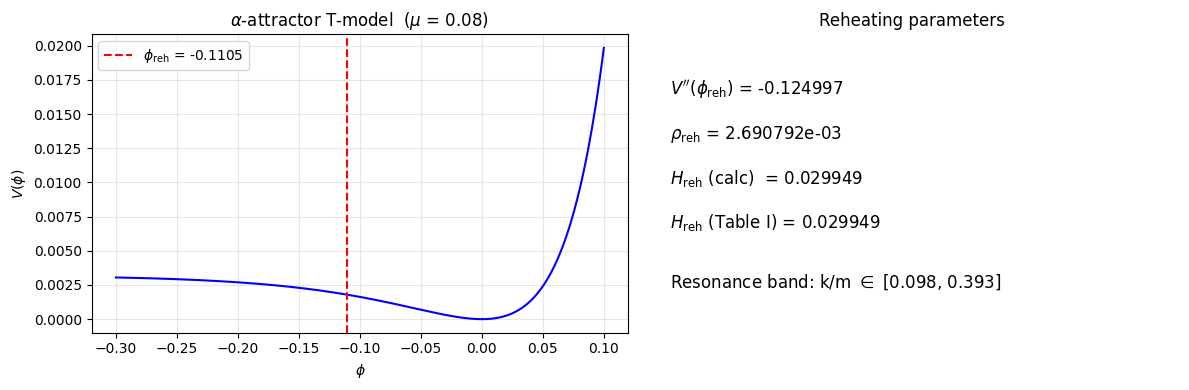

In [4]:
# Sanity check: potential shape and reheating values
phi_plot = np.linspace(-0.3, 0.1, 500)
V_plot   = np.array([my_matter.V_of_u(p) for p in phi_plot])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(phi_plot, V_plot, 'b-', lw=1.5)
axes[0].axvline(u_val, color='r', ls='--', label=f'$\phi_{{\mathrm{{reh}}}}$ = {u_val:.4f}')
axes[0].set_xlabel(r'$\phi$')
axes[0].set_ylabel(r'$V(\phi)$')
axes[0].set_title(f'$\\alpha$-attractor T-model  ($\mu$ = {mu})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# V''(phi_reh) — effective mass squared
eps = 1e-8
Vpp = (my_matter.dVdu(u_val + eps) - my_matter.dVdu(u_val - eps)) / (2 * eps)
rho_reh = 0.5 * v_val**2 + my_matter.V_of_u(u_val)
H_reh_calc = np.sqrt(rho_reh / 3.0)

axes[1].text(0.05, 0.8, f"$V''(\phi_{{\mathrm{{reh}}}})$ = {Vpp:.6f}", transform=axes[1].transAxes, fontsize=12)
axes[1].text(0.05, 0.65, f"$\\rho_{{\mathrm{{reh}}}}$ = {rho_reh:.6e}", transform=axes[1].transAxes, fontsize=12)
axes[1].text(0.05, 0.5, f"$H_{{\mathrm{{reh}}}}$ (calc)  = {H_reh_calc:.6f}", transform=axes[1].transAxes, fontsize=12)
axes[1].text(0.05, 0.35, f"$H_{{\mathrm{{reh}}}}$ (Table I) = {H_reh_expected:.6f}", transform=axes[1].transAxes, fontsize=12)
axes[1].text(0.05, 0.15, f"Resonance band: k/m $\in$ [{2*np.pi/64:.3f}, {4*2*np.pi/64:.3f}]",
             transform=axes[1].transAxes, fontsize=12)
axes[1].set_title('Reheating parameters')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## 3. Run Simulations

In [5]:
# ---- Perturbed simulation ----
initial_state = get_initial_state(
    grid, background, params_MG, my_matter,
    perturbation_amplitude, 1.0, scalar_mu, u_val, v_val, seed=seed
)

dt = T_final / num_time_points
t = np.linspace(0, T_final - dt, num_time_points)

print(f"Evolving perturbed case: T = {T_final}, dt = {dt:.4f}, CFL max_step = {0.4*min_dr:.4f}")

with tqdm(total=1000, unit="\u2030") as pbar:
    sol_pert = solve_ivp(
        get_rhs, [0, T_final], initial_state,
        args=(grid, background, my_matter, pbar, [0, T_final/1000],
              a_gauge, b_gauge, lambda_GB, coupling),
        max_step=0.4 * min_dr,
        method='RK45',
        dense_output=True,
    )

solution = sol_pert.sol(t).T
print(f"Perturbed run complete. Solution shape: {solution.shape}")

error is:  0.0006274085454352728  after iter:  1
Evolving perturbed case: T = 250, dt = 0.1250, CFL max_step = 0.1000


  0%|          | 0/1000 [00:00<?, ?‰/s]

Perturbed run complete. Solution shape: (2000, 2576)


In [6]:
# ---- Background simulation (no perturbation) ----
initial_state_bg = get_initial_state(
    grid, background, params_MG, my_matter,
    0.0, 1.0, scalar_mu, u_val, v_val, seed=seed
)

print("Evolving background (no perturbation)...")

with tqdm(total=1000, unit="\u2030") as pbar:
    sol_bg = solve_ivp(
        get_rhs, [0, T_final], initial_state_bg,
        args=(grid, background, my_matter, pbar, [0, T_final/1000],
              a_gauge, b_gauge, lambda_GB, coupling),
        max_step=0.4 * min_dr,
        method='RK45',
        dense_output=True,
    )

solution_bg = sol_bg.sol(t).T
print(f"Background run complete. Solution shape: {solution_bg.shape}")

error is:  1.7025053792287383e-16  after iter:  1
Evolving background (no perturbation)...


  0%|          | 0/1000 [00:00<?, ?‰/s]

Background run complete. Solution shape: (2000, 2576)


## 4. Quick Look — Field Evolution

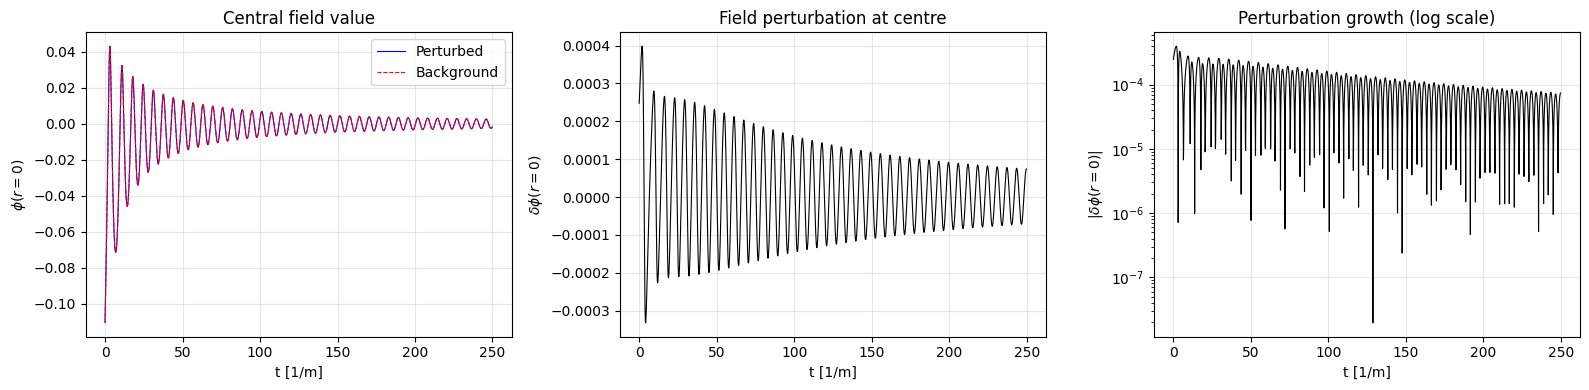

In [7]:
idx_center = NUM_GHOSTS + 2
r_center = r[idx_center]

u_center_pert = solution[:, my_matter.idx_u * num_points + idx_center]
u_center_bg   = solution_bg[:, my_matter.idx_u * num_points + idx_center]
delta_u_center = u_center_pert - u_center_bg

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(t, u_center_pert, 'b-', lw=0.8, label='Perturbed')
axes[0].plot(t, u_center_bg, 'r--', lw=0.8, label='Background')
axes[0].set_xlabel('t [1/m]')
axes[0].set_ylabel(r'$\phi(r=0)$')
axes[0].set_title('Central field value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, delta_u_center, 'k-', lw=0.8)
axes[1].set_xlabel('t [1/m]')
axes[1].set_ylabel(r'$\delta\phi(r=0)$')
axes[1].set_title('Field perturbation at centre')
axes[1].grid(True, alpha=0.3)

axes[2].semilogy(t, np.abs(delta_u_center), 'k-', lw=0.8)
axes[2].set_xlabel('t [1/m]')
axes[2].set_ylabel(r'$|\delta\phi(r=0)|$')
axes[2].set_title('Perturbation growth (log scale)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

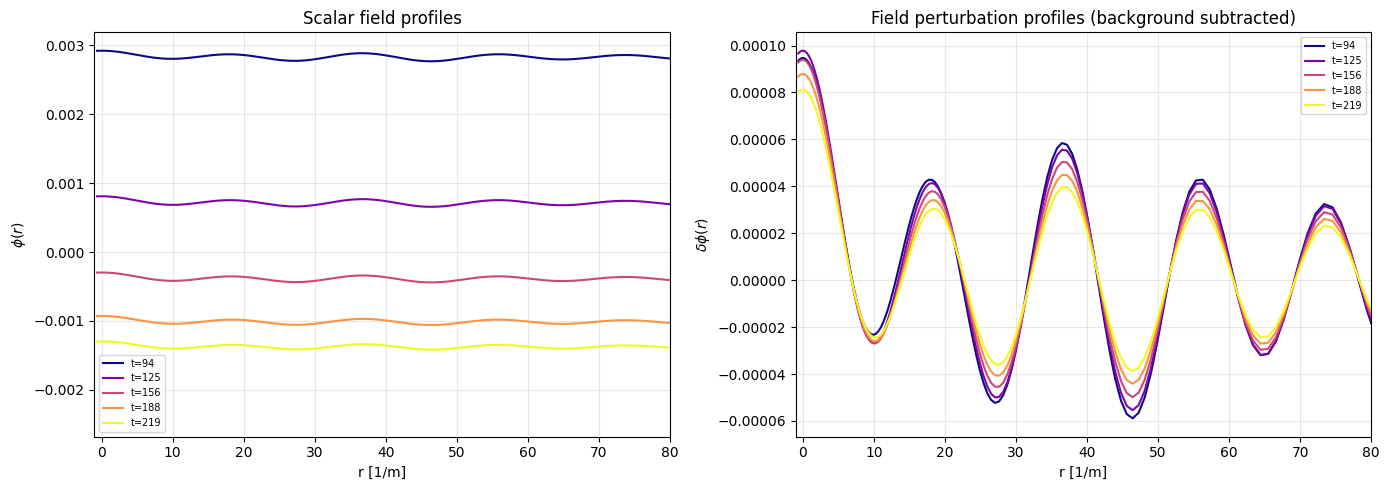

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

var_u = my_matter.idx_u
snapshot_indices = [i for i, ti in enumerate(t) if ti > 0.3*T_final and i % (num_time_points // 8) == 0]
colors = plt.cm.plasma(np.linspace(0, 1, len(snapshot_indices)))

for color, si in zip(colors, snapshot_indices):
    u_pert = solution[si, var_u * num_points:(var_u + 1) * num_points]
    u_bg   = solution_bg[si, var_u * num_points:(var_u + 1) * num_points]
    axes[0].plot(r, u_pert, color=color, label=f't={t[si]:.0f}')
    axes[1].plot(r, u_pert - u_bg, color=color, label=f't={t[si]:.0f}')

axes[0].set_xlabel('r [1/m]')
axes[0].set_ylabel(r'$\phi(r)$')
axes[0].set_title('Scalar field profiles')
axes[0].legend(fontsize=7, loc='best')
axes[0].set_xlim(-1, 80)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('r [1/m]')
axes[1].set_ylabel(r'$\delta\phi(r)$')
axes[1].set_title('Field perturbation profiles (background subtracted)')
axes[1].legend(fontsize=7, loc='best')
axes[1].set_xlim(-1, 80)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Paper Diagnostics

Running `get_oscillon_diagnostic` on the **full** solution (not background-subtracted).  
The density contrast $\delta_c = \rho_c / \bar\rho - 1$ already captures how the oscillon
stands out from the homogeneous mean.

In [9]:
params_diag = (lambda_GB, a_gauge, b_gauge, chi0, coupling)

osc = get_oscillon_diagnostic(
    solution, t, grid, background, my_matter, params_diag,
    surface_threshold=0.05,
)

print("Diagnostic keys:", list(osc.keys()))
print(f"max delta_c = {np.max(osc['delta_c']):.4f}")
print(f"max C       = {np.max(osc['C']):.6f}")
print(f"max M       = {np.max(osc['M']):.6f}")

Diagnostic keys: ['t', 'r', 'rho', 'rho_c', 'rho_bar', 'delta_c', 'a', 'M', 'V_proper', 'R', 'C']
max delta_c = 1.2218
max C       = 10.090570
max M       = 40741.501073


<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3131900/1426445765.py:3: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle(f'$\mu$ = {mu},  A = {perturbation_amplitude:.0e}', fontsize=14, y=1.01)


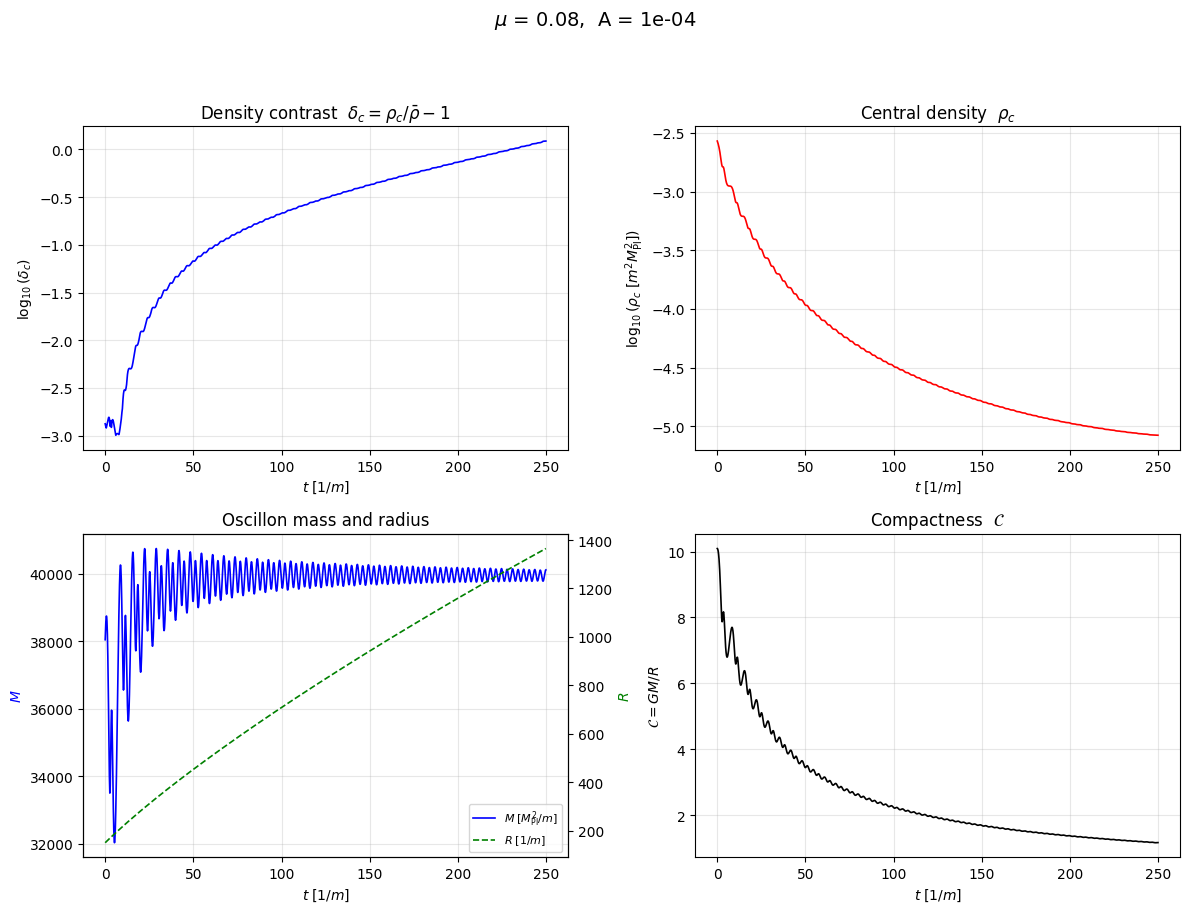

In [10]:
# ---- Figure 4 style: 2x2 panel (delta_c, rho_c, M/R, compactness) ----
fig, axes = plot_paper_diagnostics(osc, use_scale_factor=False)
fig.suptitle(f'$\mu$ = {mu},  A = {perturbation_amplitude:.0e}', fontsize=14, y=1.01)
plt.show()

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3131900/3544813038.py:3: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle(f'$\mu$ = {mu},  A = {perturbation_amplitude:.0e}  (vs $\ln a$)', fontsize=14, y=1.01)
/tmp/ipykernel_3131900/3544813038.py:3: SyntaxWarning: invalid escape sequence '\l'
  fig.suptitle(f'$\mu$ = {mu},  A = {perturbation_amplitude:.0e}  (vs $\ln a$)', fontsize=14, y=1.01)


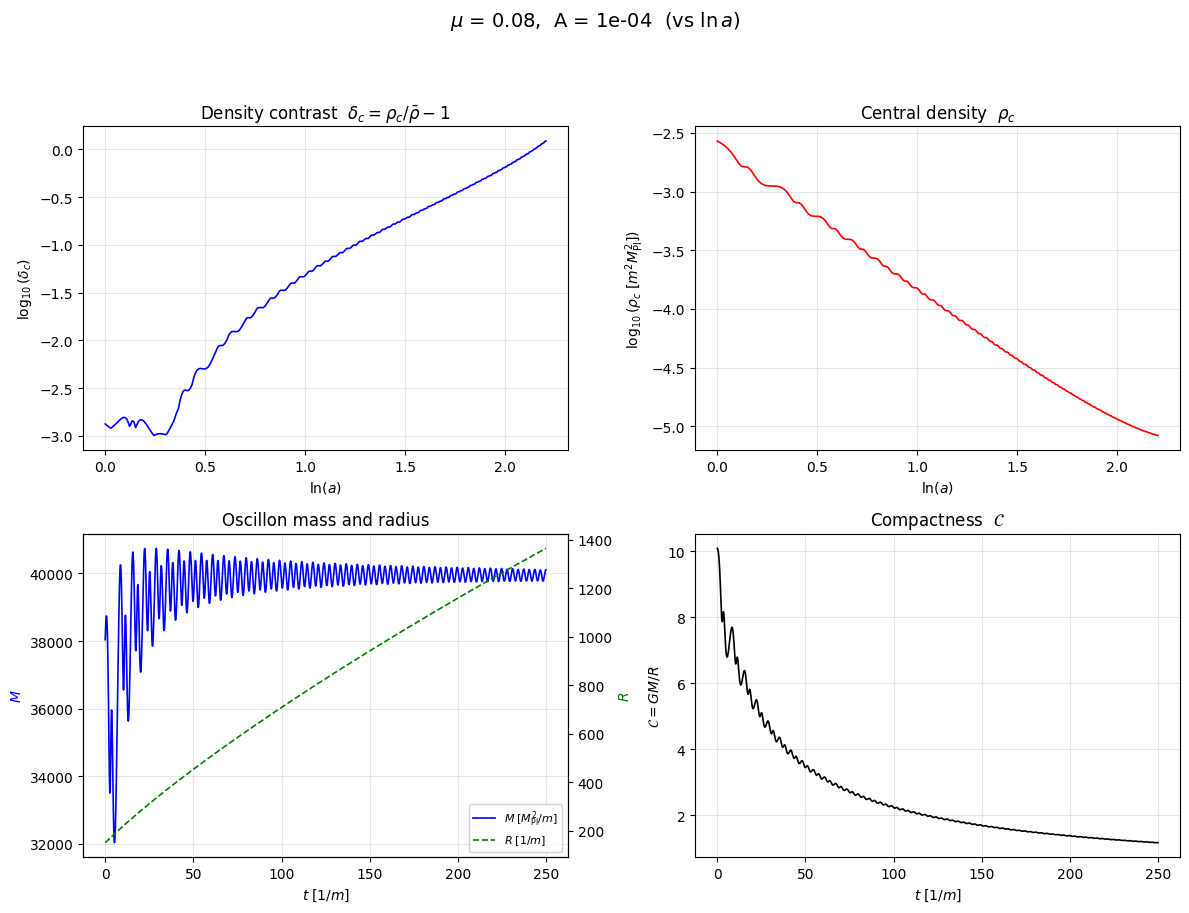

In [11]:
# ---- Same diagnostics vs ln(a) (paper convention) ----
fig, axes = plot_paper_diagnostics(osc, use_scale_factor=True)
fig.suptitle(f'$\mu$ = {mu},  A = {perturbation_amplitude:.0e}  (vs $\ln a$)', fontsize=14, y=1.01)
plt.show()

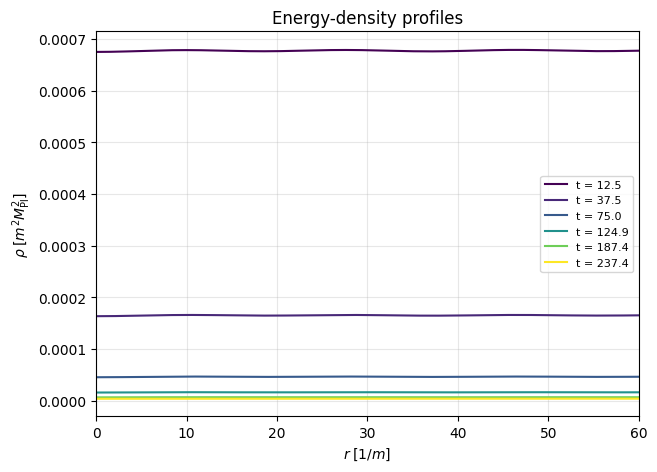

In [12]:
# ---- Figure 2 style: energy-density profiles at selected times ----
T_end = osc["t"][-1]
snapshot_times = [0.05*T_end, 0.15*T_end, 0.3*T_end, 0.5*T_end, 0.75*T_end, 0.95*T_end]
ax = plot_density_profiles_at_times(osc, times=snapshot_times)
ax.set_xlim(0, 60)
plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3131900/2583674971.py:47: SyntaxWarning: invalid escape sequence '\m'
  fig.suptitle(f'Oscillon diagnostics:  $\mu$ = {mu},  A = {perturbation_amplitude:.0e}', fontsize=13)


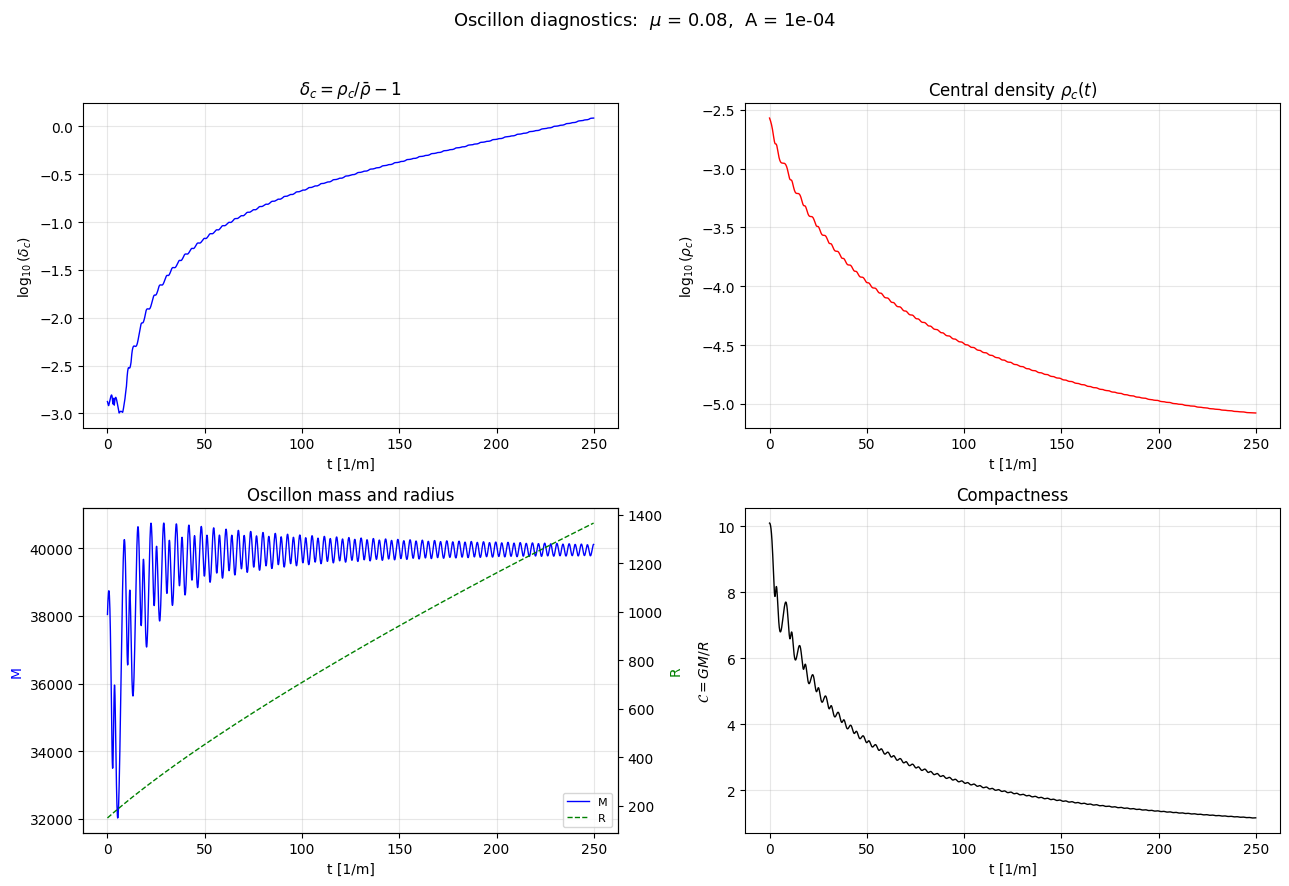

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# (a) Density contrast
ax = axes[0, 0]
pos = osc["delta_c"] > 0
y = np.full_like(osc["delta_c"], np.nan)
y[pos] = np.log10(osc["delta_c"][pos])
ax.plot(t, y, 'b-', lw=1)
ax.set_xlabel('t [1/m]')
ax.set_ylabel(r'$\log_{10}(\delta_c)$')
ax.set_title(r'$\delta_c = \rho_c / \bar\rho - 1$')
ax.grid(True, alpha=0.3)

# (b) Central density
ax = axes[0, 1]
pos_rho = osc["rho_c"] > 0
y2 = np.full_like(osc["rho_c"], np.nan)
y2[pos_rho] = np.log10(osc["rho_c"][pos_rho])
ax.plot(t, y2, 'r-', lw=1)
ax.set_xlabel('t [1/m]')
ax.set_ylabel(r'$\log_{10}(\rho_c)$')
ax.set_title(r'Central density $\rho_c(t)$')
ax.grid(True, alpha=0.3)

# (c) Mass and Radius
ax = axes[1, 0]
ax.plot(t, osc["M"], 'b-', lw=1, label='M')
ax2 = ax.twinx()
ax2.plot(t, osc["R"], 'g--', lw=1, label='R')
ax.set_xlabel('t [1/m]')
ax.set_ylabel('M', color='b')
ax2.set_ylabel('R', color='g')
ax.set_title('Oscillon mass and radius')
lines1, l1 = ax.get_legend_handles_labels()
lines2, l2 = ax2.get_legend_handles_labels()
ax.legend(lines1+lines2, l1+l2, fontsize=8)
ax.grid(True, alpha=0.3)

# (d) Compactness
ax = axes[1, 1]
ax.plot(t, osc["C"], 'k-', lw=1)
ax.set_xlabel('t [1/m]')
ax.set_ylabel(r'$\mathcal{C} = GM/R$')
ax.set_title('Compactness')
ax.grid(True, alpha=0.3)

fig.suptitle(f'Oscillon diagnostics:  $\mu$ = {mu},  A = {perturbation_amplitude:.0e}', fontsize=13)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

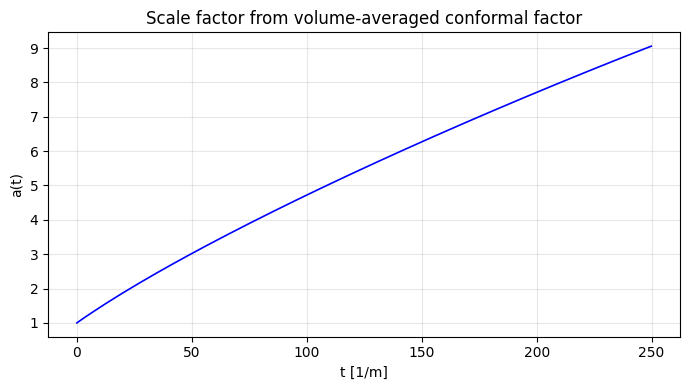

Final scale factor: a = 9.0553
Number of e-folds:  ln(a) = 2.203


: 

In [ ]:
# ---- Scale factor evolution ----
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(t, osc["a"], 'b-', lw=1.2)
ax.set_xlabel('t [1/m]')
ax.set_ylabel('a(t)')
ax.set_title('Scale factor from volume-averaged conformal factor')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final scale factor: a = {osc['a'][-1]:.4f}")
print(f"Number of e-folds:  ln(a) = {np.log(max(osc['a'][-1], 1e-30)):.3f}")

## 6. Multi-Amplitude Comparison (Figure 4 bottom style)

Loop over several perturbation amplitudes $A = \sqrt{\langle\delta\phi^2\rangle}$
and compare $\delta_c(t)$ and $\mathcal{C}(t)$.

The paper shows that larger initial fluctuations produce more compact oscillons.

In [ ]:
# ---- Amplitudes to compare ----
amplitudes = [1e-6, 1e-5, 1e-4]
labels_amp = [f'A = {a:.0e}' for a in amplitudes]

osc_results = []

for idx_a, A in enumerate(amplitudes):
    print(f"\n=== Running A = {A:.0e} ({idx_a+1}/{len(amplitudes)}) ===")

    init = get_initial_state(
        grid, background, params_MG, my_matter,
        A, 1.0, scalar_mu, u_val, v_val, seed=seed
    )

    with tqdm(total=1000, unit="\u2030", desc=f"A={A:.0e}") as pbar:
        dense = solve_ivp(
            get_rhs, [0, T_final], init,
            args=(grid, background, my_matter, pbar, [0, T_final/1000],
                  a_gauge, b_gauge, lambda_GB, coupling),
            max_step=0.4 * min_dr,
            method='RK45',
            dense_output=True,
        )
    sol_a = dense.sol(t).T

    osc_a = get_oscillon_diagnostic(
        sol_a, t, grid, background, my_matter, params_diag,
        surface_threshold=0.05,
    )
    osc_results.append(osc_a)
    print(f"  max delta_c = {np.max(osc_a['delta_c']):.4f},  max C = {np.max(osc_a['C']):.6f}")

print("\nAll runs complete.")


=== Running A = 1e-06 (1/3) ===
error is:  6.27314975035456e-06  after iter:  1


A=1e-06:   0%|          | 0/1000 [00:00<?, ?‰/s]

In [ ]:
# ---- Density contrast comparison (Fig. 4 top style) ----
fig, ax = plot_density_contrast_comparison(osc_results, labels=labels_amp,
                                           use_scale_factor=False)
ax.set_title(f'$\delta_c$ growth for different amplitudes  ($\mu$ = {mu})')
plt.show()

In [ ]:
# ---- Compactness comparison (Fig. 1 style) ----
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(amplitudes)))

for i, (osc_a, lbl) in enumerate(zip(osc_results, labels_amp)):
    axes[0].plot(osc_a["t"], osc_a["C"], color=colors[i], lw=1.2, label=lbl)
    axes[1].plot(osc_a["t"], osc_a["M"], color=colors[i], lw=1.2, label=lbl)
    axes[2].plot(osc_a["t"], osc_a["R"], color=colors[i], lw=1.2, label=lbl)

axes[0].set_xlabel('t [1/m]')
axes[0].set_ylabel(r'$\mathcal{C} = GM/R$')
axes[0].set_title('Compactness')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('t [1/m]')
axes[1].set_ylabel(r'$M \; [M_{\rm Pl}^2/m]$')
axes[1].set_title('Oscillon mass')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

axes[2].set_xlabel('t [1/m]')
axes[2].set_ylabel(r'$R \; [1/m]$')
axes[2].set_title('Oscillon radius')
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)

fig.suptitle(f'Oscillon properties vs amplitude  ($\mu$ = {mu})', fontsize=13)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
# ---- Central density comparison (Fig. 4 bottom style) ----
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(amplitudes)))

for i, (osc_a, lbl) in enumerate(zip(osc_results, labels_amp)):
    rho_c = osc_a["rho_c"]
    pos = rho_c > 0
    y = np.full_like(rho_c, np.nan)
    y[pos] = np.log10(rho_c[pos])
    ax.plot(osc_a["t"], y, color=colors[i], lw=1.2, label=lbl)

ax.set_xlabel('t [1/m]')
ax.set_ylabel(r'$\log_{10}(\rho_c)$')
ax.set_title(f'Central density evolution  ($\mu$ = {mu})')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ---- Density profile snapshots for each amplitude ----
fig, axes = plt.subplots(1, len(amplitudes), figsize=(6*len(amplitudes), 5), sharey=True)
if len(amplitudes) == 1:
    axes = [axes]

for i, (osc_a, lbl) in enumerate(zip(osc_results, labels_amp)):
    T_end = osc_a["t"][-1]
    times = [0.3*T_end, 0.5*T_end, 0.7*T_end, 0.9*T_end]
    plot_density_profiles_at_times(osc_a, times=times, ax=axes[i])
    axes[i].set_title(lbl)
    axes[i].set_xlim(0, 50)

plt.suptitle(f'Energy-density profiles  ($\mu$ = {mu})', fontsize=13)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
# ---- Summary table ----
print(f"{'Amplitude':>12s}  {'max delta_c':>12s}  {'max C':>10s}  {'max M':>10s}  {'max R':>10s}")
print("-" * 60)
for amp, osc_a in zip(amplitudes, osc_results):
    print(f"{amp:12.0e}  {np.max(osc_a['delta_c']):12.4f}  "
          f"{np.max(osc_a['C']):10.6f}  {np.max(osc_a['M']):10.4f}  "
          f"{np.max(osc_a['R']):10.4f}")

## Notes

**To change $\mu$:** update the `mu` variable in cell 3. The Table I values are looked up
automatically and the potential is monkey-patched to use the correct $\mu$.

**For Figures 1 and 5 (properties vs $\mu$):** run this notebook for each $\mu$ value
and collect the final oscillon properties. You can wrap the full pipeline in a loop over
`TABLE_I.keys()` for an automated scan.

**Gauge choice:** the code uses geodesic slicing ($\dot\alpha = 0$) and zero shift ($\beta = 0$),
giving cosmic time as the time coordinate. The paper uses modified 1+log slicing and Gamma-driver.

**Resolution:** increase resolution by decreasing `min_dr` (e.g. 1/8 or 1/16) for convergence tests.

**Evolution time:** for 3 e-folds, longer runs may be needed (T > 1000). Adjust `T_final` accordingly.